# Dev Phase 1: Data Acquisition & Preprocessing Tests

This notebook tests all Phase 1 deliverables:
- Data loading from parquet
- 1-minute to 5-minute aggregation
- Rollover detection and adjustment
- Data validation
- Returns preservation verification

In [1]:
# Setup: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
from pathlib import Path

# Define base path and add to sys.path for imports
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Transformers/FP")
sys.path.insert(0, str(BASE_DIR))

# Define data paths
RAW_DIR = BASE_DIR / "data/raw"
INTERIM_DIR = BASE_DIR / "data/interim"

# Create interim directory if it doesn't exist
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Raw data directory: {RAW_DIR}")
print(f"Interim data directory: {INTERIM_DIR}")

Mounted at /content/drive
Base directory: /content/drive/MyDrive/Colab Notebooks/Transformers/FP
Raw data directory: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/raw
Interim data directory: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/interim


In [2]:
# Import modules
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import Phase 1 modules from package structure
from src.data import DataLoader, RolloverAdjuster

print("✓ All imports successful")

✓ All imports successful


## Test 1: Data Loading

In [3]:
# Initialize DataLoader
loader = DataLoader(raw_dir=RAW_DIR, interim_dir=INTERIM_DIR)

# Test loading 1-minute data
print("Loading 1-minute data...")
df_1min = loader.load_1min_data()

print(f"✓ Loaded {len(df_1min):,} 1-minute bars")
print(f"Date range: {df_1min.index[0]} to {df_1min.index[-1]}")
print(f"Columns: {list(df_1min.columns)}")
print(f"\nFirst 5 rows:")
df_1min.head()

Loading 1-minute data...
✓ Loaded 5,236,084 1-minute bars
Date range: 2010-06-07 00:00:00+00:00 to 2025-12-03 23:59:00+00:00
Columns: ['open', 'high', 'low', 'close', 'volume']

First 5 rows:


,open,high,low,close,volume
timestamp,,,,,
2010-06-07 00:00:00+00:00,1826.25,1826.50,1826.00,1826.50,6
2010-06-07 00:01:00+00:00,1826.50,1826.50,1826.50,1826.50,6
2010-06-07 00:02:00+00:00,1826.50,1826.50,1825.75,1825.75,7
2010-06-07 00:03:00+00:00,1825.50,1826.25,1825.50,1825.75,16
2010-06-07 00:04:00+00:00,1826.00,1827.25,1826.00,1827.25,48


In [4]:
# Validate data structure
assert isinstance(df_1min.index, pd.DatetimeIndex), "Index must be DatetimeIndex"
assert str(df_1min.index.tz.zone) == 'UTC', "Index must be UTC timezone"
assert all(col in df_1min.columns for col in ['open', 'high', 'low', 'close', 'volume']), \
    "Missing required columns"
assert df_1min.index.is_monotonic_increasing, "Index must be sorted"

print("✓ Data structure validation passed")

✓ Data structure validation passed


## Test 2: Data Filtering

In [5]:
# Test invalid tick filtering
print(f"Bars before filtering: {len(df_1min):,}")
df_1min_clean = loader.filter_invalid_ticks(df_1min)
print(f"Bars after filtering: {len(df_1min_clean):,}")
print(f"Removal rate: {(1 - len(df_1min_clean)/len(df_1min))*100:.4f}%")

# Verify no zero or negative values
assert (df_1min_clean[['open', 'high', 'low', 'close']] > 0).all().all(), \
    "Found zero or negative prices after filtering"
assert (df_1min_clean['volume'] > 0).all(), "Found zero volume after filtering"

print("✓ Invalid tick filtering passed")

Bars before filtering: 5,236,084
Bars after filtering: 5,236,084
Removal rate: 0.0000%
✓ Invalid tick filtering passed


## Test 3: 5-Minute Aggregation

In [6]:
# Aggregate to 5-minute bars
print("Aggregating to 5-minute bars...")
df_5min = loader.aggregate_to_5min(df_1min_clean, validate=True)

print(f"✓ Created {len(df_5min):,} 5-minute bars")
print(f"Date range: {df_5min.index[0]} to {df_5min.index[-1]}")
print(f"Aggregation ratio: {len(df_1min_clean) / len(df_5min):.2f}:1")
print(f"\nFirst 5 rows:")
df_5min.head()

Aggregating to 5-minute bars...
✓ Created 1,086,930 5-minute bars
Date range: 2010-06-07 00:00:00+00:00 to 2025-12-03 23:55:00+00:00
Aggregation ratio: 4.82:1

First 5 rows:


,open,high,low,close,volume
timestamp,,,,,
2010-06-07 00:00:00+00:00,1826.25,1827.25,1825.50,1827.25,83
2010-06-07 00:05:00+00:00,1827.50,1827.50,1825.50,1826.75,92
2010-06-07 00:10:00+00:00,1827.25,1827.25,1820.75,1821.75,229
2010-06-07 00:15:00+00:00,1821.50,1822.50,1820.50,1820.50,127
2010-06-07 00:20:00+00:00,1821.00,1821.50,1819.25,1819.25,126


In [7]:
# Validate OHLC relationships
assert (df_5min['high'] >= df_5min['low']).all(), "High < Low violation"
assert (df_5min['high'] >= df_5min['open']).all(), "High < Open violation"
assert (df_5min['high'] >= df_5min['close']).all(), "High < Close violation"
assert (df_5min['low'] <= df_5min['open']).all(), "Low > Open violation"
assert (df_5min['low'] <= df_5min['close']).all(), "Low > Close violation"

print("✓ OHLC relationship validation passed")

✓ OHLC relationship validation passed


In [8]:
# Save aggregated data
output_path = INTERIM_DIR / "nq_ohlcv_5min_aggregated.parquet"
df_5min.to_parquet(output_path)
print(f"✓ Saved aggregated data to {output_path}")

✓ Saved aggregated data to /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/interim/nq_ohlcv_5min_aggregated.parquet


## Test 4: Trading Halt Detection

In [9]:
# Detect trading halts
df_5min_halts = loader.detect_trading_halts(df_5min, max_gap_minutes=15)

# Analyze halt distribution
halt_count = df_5min_halts['is_post_halt'].sum()
print(f"Total trading halts detected: {halt_count:,}")
print(f"Halt frequency: {halt_count / len(df_5min_halts) * 100:.3f}% of bars")

# Show sample halts
if halt_count > 0:
    print("\nSample halt instances:")
    halt_samples = df_5min_halts[df_5min_halts['is_post_halt']].head(10)
    print(halt_samples[['open', 'high', 'low', 'close', 'volume']])

print("✓ Trading halt detection completed")

Detected 6604 trading halts (gaps > 15 min)
Total trading halts detected: 6,604
Halt frequency: 0.608% of bars

Sample halt instances:
                              open     high      low    close  volume
timestamp                                                            
2010-06-07 20:30:00+00:00  1795.00  1796.25  1795.00  1796.25     165
2010-06-07 22:00:00+00:00  1795.75  1796.50  1794.00  1794.25      71
2010-06-08 20:30:00+00:00  1791.75  1794.25  1790.25  1793.50     878
2010-06-08 22:00:00+00:00  1794.00  1794.00  1791.50  1791.50      93
2010-06-09 20:30:00+00:00  1780.50  1781.25  1779.75  1779.75     256
2010-06-09 22:00:00+00:00  1776.75  1777.75  1775.25  1776.00     137
2010-06-10 20:30:00+00:00  1821.25  1823.25  1821.00  1822.75     228
2010-06-10 22:00:00+00:00  1824.75  1825.75  1824.25  1824.75      19
2010-06-13 22:00:00+00:00  1848.00  1877.75  1845.25  1851.00     152
2010-06-14 20:30:00+00:00  1845.50  1846.50  1844.75  1846.50     148
✓ Trading halt detection 

## Test 5: Rollover Detection

In [10]:
# Detect rollovers from price discontinuities
print("Detecting contract rollovers...")
adjuster = RolloverAdjuster.from_data(
    df_5min,
    price_jump_threshold=0.01  # 1% minimum jump
)

# Get rollover metadata
rollover_df = adjuster.get_rollover_dates()

print(f"✓ Detected {len(rollover_df)} rollovers")
print(f"\nRollover dates and price ratios:")
print(rollover_df)

Detecting contract rollovers...
✓ Detected 145 rollovers

Rollover dates and price ratios:
                         date  price_ratio
0   2011-07-24 22:00:00+00:00     0.986203
1   2011-07-31 22:00:00+00:00     1.011211
2   2011-08-01 14:00:00+00:00     0.989653
3   2011-08-05 12:30:00+00:00     1.010355
4   2011-08-07 22:00:00+00:00     0.978998
..                        ...          ...
140 2025-04-22 22:00:00+00:00     1.021025
141 2025-05-06 22:00:00+00:00     1.010203
142 2025-05-11 22:00:00+00:00     1.013588
143 2025-06-18 00:00:00+00:00     1.011023
144 2025-10-12 22:00:00+00:00     1.020950

[145 rows x 2 columns]


In [11]:
# Save rollover metadata
rollover_path = RAW_DIR / "rollover_dates.csv"
rollover_df.to_csv(rollover_path, index=False)
print(f"✓ Saved rollover metadata to {rollover_path}")

✓ Saved rollover metadata to /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/raw/rollover_dates.csv


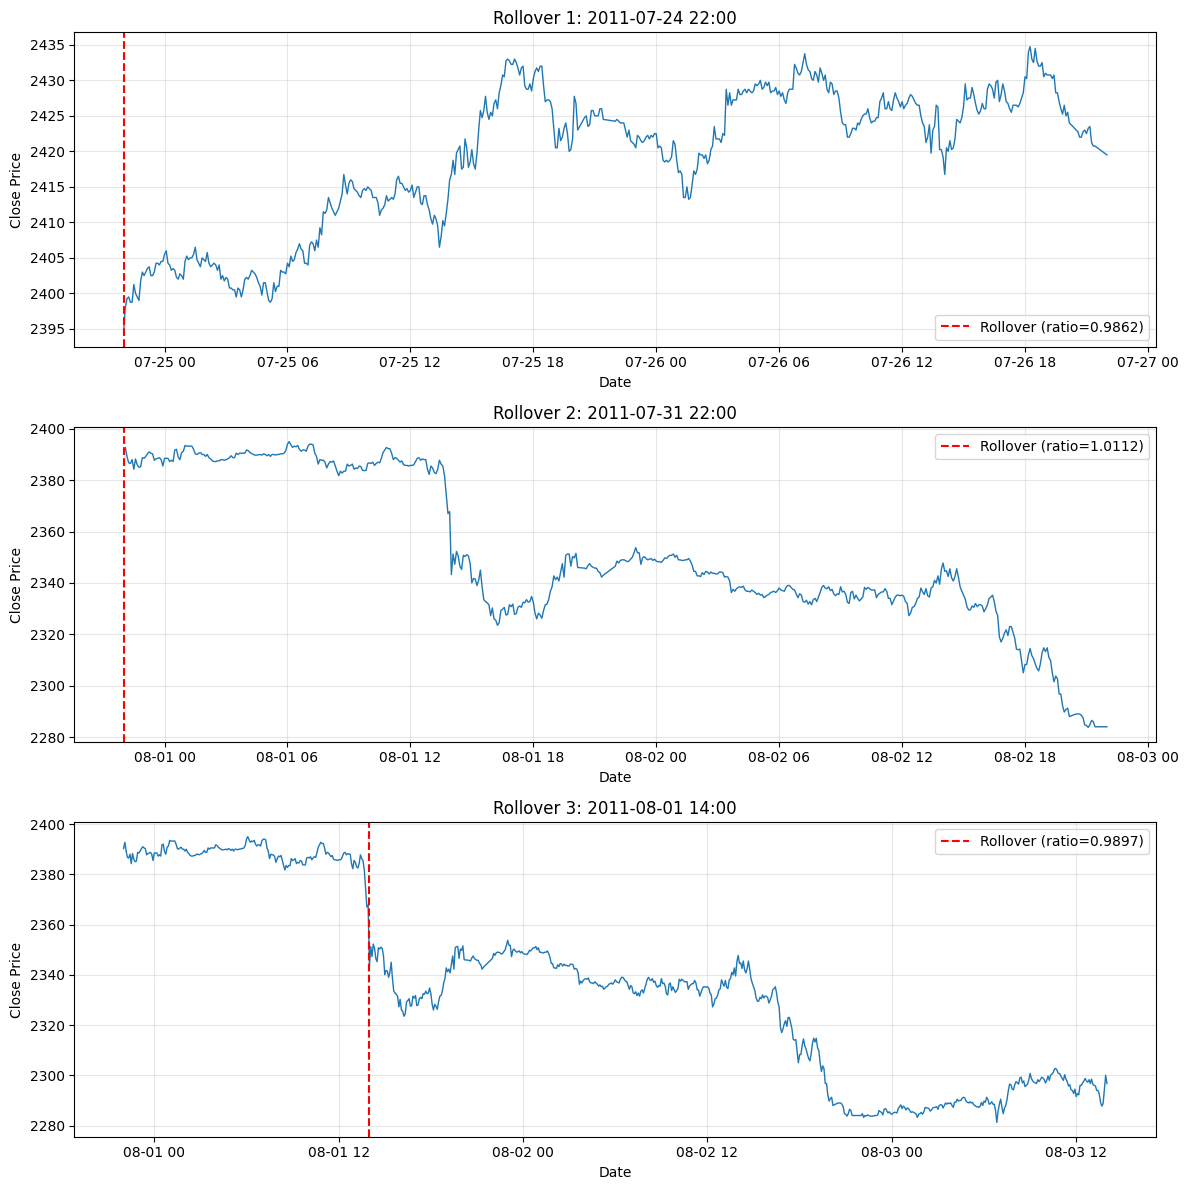

✓ Rollover visualization complete


In [12]:
# Visualize price jumps at rollovers
if len(rollover_df) > 0:
    fig, axes = plt.subplots(min(3, len(rollover_df)), 1, figsize=(12, 4*min(3, len(rollover_df))))

    if len(rollover_df) == 1:
        axes = [axes]

    for idx, (_, rollover) in enumerate(rollover_df.head(3).iterrows()):
        rollover_date = rollover['date']

        # Get data around rollover (±2 days)
        start = rollover_date - pd.Timedelta(days=2)
        end = rollover_date + pd.Timedelta(days=2)
        window = df_5min.loc[start:end, 'close']

        # Plot
        axes[idx].plot(window.index, window.values, linewidth=1)
        axes[idx].axvline(rollover_date, color='red', linestyle='--',
                         label=f'Rollover (ratio={rollover["price_ratio"]:.4f})')
        axes[idx].set_title(f'Rollover {idx+1}: {rollover_date.strftime("%Y-%m-%d %H:%M")}')
        axes[idx].set_xlabel('Date')
        axes[idx].set_ylabel('Close Price')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("✓ Rollover visualization complete")

## Test 6: Ratio Back-Adjustment

In [13]:
# Apply ratio back-adjustment
print("Applying ratio back-adjustment...")
df_adjusted = adjuster.adjust_prices(df_5min)

print(f"✓ Adjusted {len(df_adjusted):,} bars")
print(f"\nPrice statistics comparison:")
print(f"\nOriginal data:")
print(df_5min[['open', 'high', 'low', 'close']].describe())
print(f"\nAdjusted data:")
print(df_adjusted[['open', 'high', 'low', 'close']].describe())

Applying ratio back-adjustment...
✓ Adjusted 1,086,930 bars

Price statistics comparison:

Original data:
               open          high           low         close
count  1.086930e+06  1.086930e+06  1.086930e+06  1.086930e+06
mean   8.688070e+03  8.691937e+03  8.684121e+03  8.688086e+03
std    6.184062e+03  6.186815e+03  6.181203e+03  6.184071e+03
min    1.702250e+03  1.707250e+03  1.698000e+03  1.702250e+03
25%    3.664500e+03  3.665750e+03  3.663250e+03  3.664500e+03
50%    6.654250e+03  6.658250e+03  6.650625e+03  6.654250e+03
75%    1.314900e+04  1.315700e+04  1.314150e+04  1.314900e+04
max    2.639400e+04  2.639900e+04  2.638050e+04  2.639550e+04

Adjusted data:
               open          high           low         close
count  1.086930e+06  1.086930e+06  1.086930e+06  1.086930e+06
mean   8.456383e+03  8.460205e+03  8.452476e+03  8.456398e+03
std    6.964946e+03  6.968070e+03  6.961706e+03  6.964955e+03
min    1.318748e+03  1.322621e+03  1.315455e+03  1.318748e+03
25%    2.8

In [14]:
# Verify OHLC relationships preserved after adjustment
assert (df_adjusted['high'] >= df_adjusted['low']).all(), "OHLC violation after adjustment"
assert (df_adjusted['high'] >= df_adjusted['open']).all(), "OHLC violation after adjustment"
assert (df_adjusted['high'] >= df_adjusted['close']).all(), "OHLC violation after adjustment"
assert (df_adjusted['low'] <= df_adjusted['open']).all(), "OHLC violation after adjustment"
assert (df_adjusted['low'] <= df_adjusted['close']).all(), "OHLC violation after adjustment"

print("✓ OHLC relationships preserved after adjustment")

✓ OHLC relationships preserved after adjustment


## Test 7: Returns Preservation Verification

In [15]:
# Verify log-returns are preserved
print("Verifying returns preservation...")
returns_preserved = adjuster.verify_returns_preserved(
    original=df_5min,
    adjusted=df_adjusted,
    tolerance=1e-10
)

assert returns_preserved, "Returns preservation check failed"
print("✓ Returns preservation verification passed")

Verifying returns preservation...
✓ Returns preserved: max difference 3.77e-15 < tolerance 1.00e-10
✓ Returns preservation verification passed


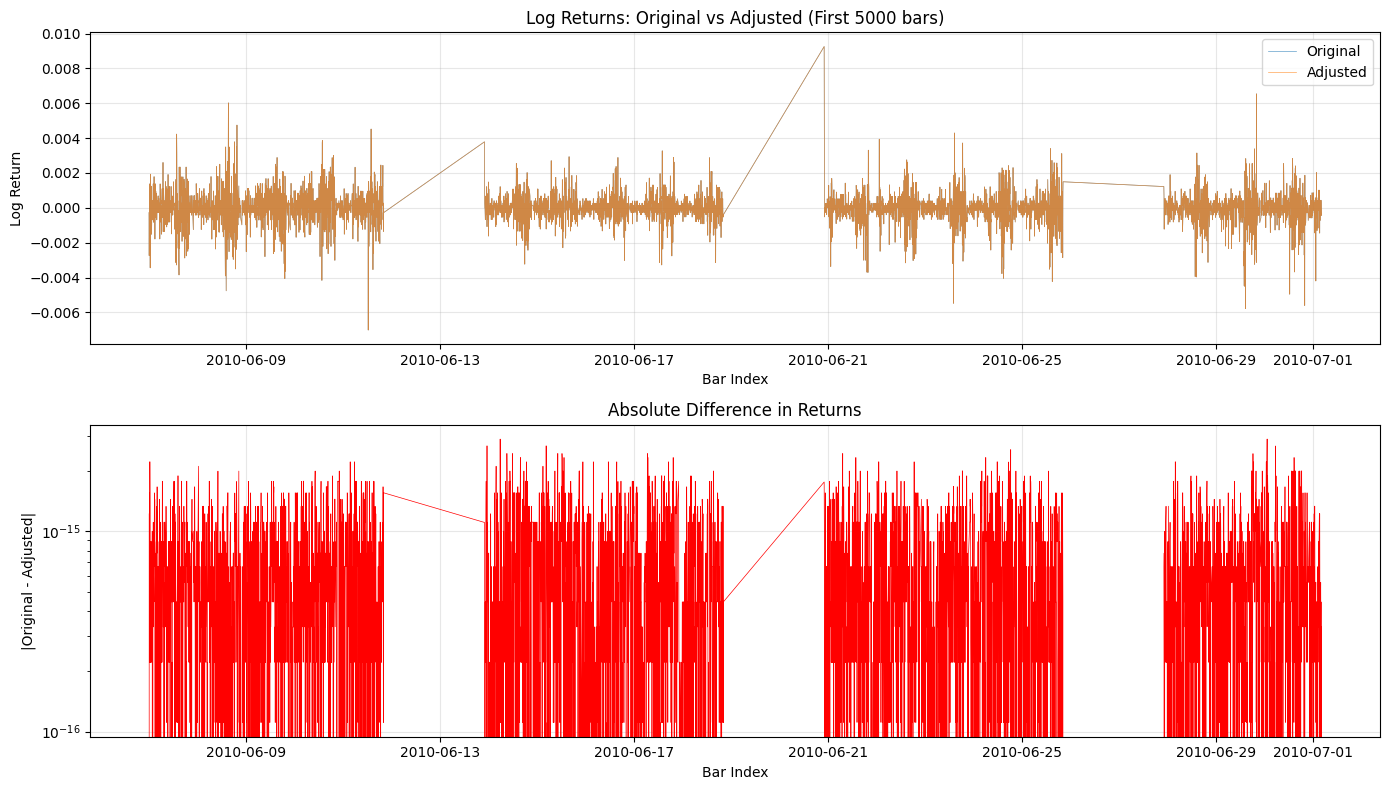


Return difference statistics:
Mean: 2.06e-06
Max: 4.64e-02
Median: 3.33e-16


In [16]:
# Visual comparison of returns before/after adjustment
orig_returns = np.log(df_5min['close'] / df_5min['close'].shift(1))
adj_returns = np.log(df_adjusted['close'] / df_adjusted['close'].shift(1))

# Calculate difference
return_diff = (orig_returns - adj_returns).abs()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Returns comparison
sample_size = min(5000, len(orig_returns))
axes[0].plot(orig_returns.iloc[:sample_size], label='Original', alpha=0.7, linewidth=0.5)
axes[0].plot(adj_returns.iloc[:sample_size], label='Adjusted', alpha=0.7, linewidth=0.5)
axes[0].set_title('Log Returns: Original vs Adjusted (First 5000 bars)')
axes[0].set_xlabel('Bar Index')
axes[0].set_ylabel('Log Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Difference
axes[1].plot(return_diff.iloc[:sample_size], color='red', linewidth=0.5)
axes[1].set_title('Absolute Difference in Returns')
axes[1].set_xlabel('Bar Index')
axes[1].set_ylabel('|Original - Adjusted|')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReturn difference statistics:")
print(f"Mean: {return_diff.mean():.2e}")
print(f"Max: {return_diff.max():.2e}")
print(f"Median: {return_diff.median():.2e}")

In [17]:
# Save adjusted data
adjusted_path = INTERIM_DIR / "nq_ohlcv_5min_adjusted.parquet"
df_adjusted.to_parquet(adjusted_path)
print(f"✓ Saved adjusted data to {adjusted_path}")

✓ Saved adjusted data to /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/interim/nq_ohlcv_5min_adjusted.parquet


## Test 8: Adjustment Factor Analysis

Adjustment factor statistics:
count    1.086930e+06
mean     8.918262e-01
std      1.345201e-01
min      7.615301e-01
25%      7.747086e-01
50%      8.142408e-01
75%      9.873431e-01
max      1.237269e+00
dtype: float64


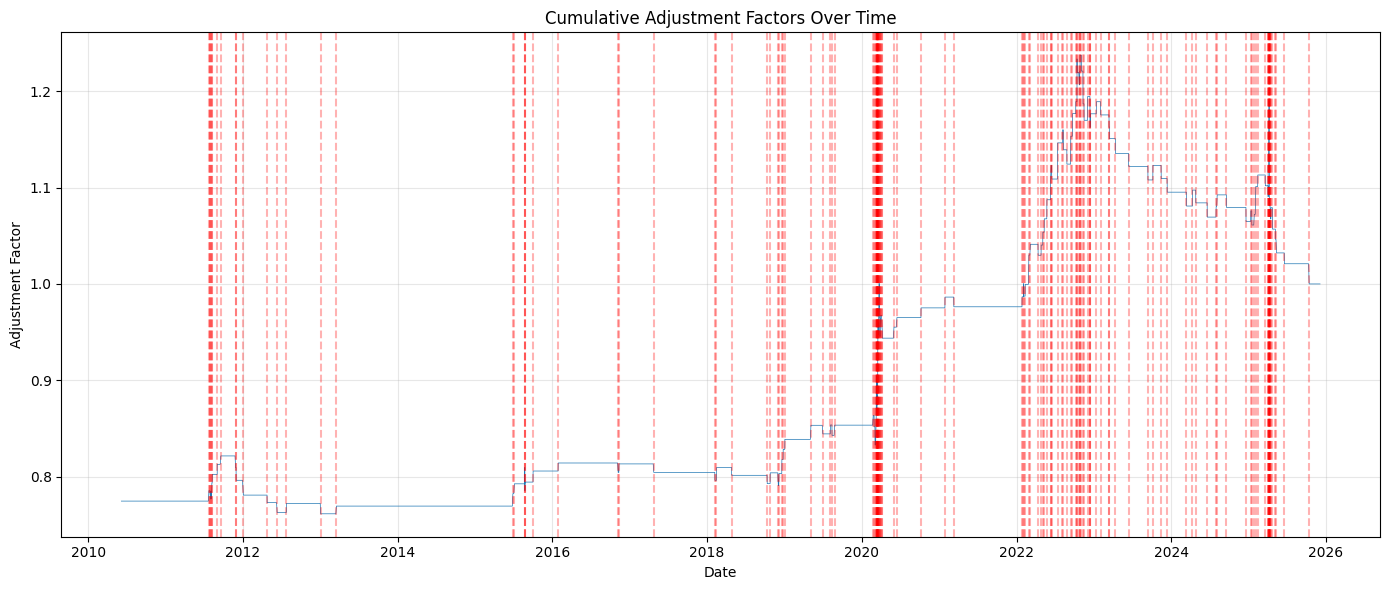

✓ Adjustment factor analysis complete


In [18]:
# Get adjustment factors over time
adj_factors = adjuster.get_adjustment_factors(df_5min)

print(f"Adjustment factor statistics:")
print(adj_factors.describe())

# Plot adjustment factors over time
plt.figure(figsize=(14, 6))
plt.plot(adj_factors.index, adj_factors.values, linewidth=0.5)
plt.title('Cumulative Adjustment Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Adjustment Factor')
plt.grid(True, alpha=0.3)

# Mark rollover dates
if len(rollover_df) > 0:
    for _, rollover in rollover_df.iterrows():
        plt.axvline(rollover['date'], color='red', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("✓ Adjustment factor analysis complete")

## Test 9: Data Quality Summary

In [19]:
# Generate comprehensive data quality report
print("="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

print(f"\n1. DATA COVERAGE")
print(f"   Start date: {df_adjusted.index[0]}")
print(f"   End date: {df_adjusted.index[-1]}")
print(f"   Total days: {(df_adjusted.index[-1] - df_adjusted.index[0]).days}")
print(f"   Total 5-min bars: {len(df_adjusted):,}")

print(f"\n2. ROLLOVER ADJUSTMENTS")
print(f"   Number of rollovers: {len(rollover_df)}")
if len(rollover_df) > 0:
    print(f"   First rollover: {rollover_df['date'].iloc[0]}")
    print(f"   Last rollover: {rollover_df['date'].iloc[-1]}")
    print(f"   Mean price ratio: {rollover_df['price_ratio'].mean():.4f}")
    print(f"   Min price ratio: {rollover_df['price_ratio'].min():.4f}")
    print(f"   Max price ratio: {rollover_df['price_ratio'].max():.4f}")

print(f"\n3. PRICE STATISTICS (Adjusted)")
print(f"   Close price range: {df_adjusted['close'].min():.2f} - {df_adjusted['close'].max():.2f}")
print(f"   Mean close: {df_adjusted['close'].mean():.2f}")
print(f"   Median close: {df_adjusted['close'].median():.2f}")

print(f"\n4. VOLUME STATISTICS")
print(f"   Total volume: {df_adjusted['volume'].sum():,.0f}")
print(f"   Mean volume: {df_adjusted['volume'].mean():,.0f}")
print(f"   Median volume: {df_adjusted['volume'].median():,.0f}")

print(f"\n5. RETURNS ANALYSIS (Log Returns)")
returns = np.log(df_adjusted['close'] / df_adjusted['close'].shift(1))
print(f"   Mean return: {returns.mean():.6f}")
print(f"   Std dev: {returns.std():.6f}")
print(f"   Skewness: {returns.skew():.4f}")
print(f"   Kurtosis: {returns.kurtosis():.4f}")
print(f"   Min return: {returns.min():.6f}")
print(f"   Max return: {returns.max():.6f}")

print(f"\n6. DATA QUALITY CHECKS")
print(f"   ✓ No zero prices")
print(f"   ✓ No negative prices")
print(f"   ✓ OHLC relationships valid")
print(f"   ✓ Returns preserved after adjustment")
print(f"   ✓ Data sorted chronologically")

print(f"\n7. TRADING HALTS")
if 'is_post_halt' in df_5min_halts.columns:
    print(f"   Total halts detected: {df_5min_halts['is_post_halt'].sum():,}")
    print(f"   Halt frequency: {df_5min_halts['is_post_halt'].mean()*100:.3f}%")

print(f"\n" + "="*60)
print("✓ ALL PHASE 1 TESTS PASSED")
print("="*60)

DATA QUALITY SUMMARY

1. DATA COVERAGE
   Start date: 2010-06-07 00:00:00+00:00
   End date: 2025-12-03 23:55:00+00:00
   Total days: 5658
   Total 5-min bars: 1,086,930

2. ROLLOVER ADJUSTMENTS
   Number of rollovers: 145
   First rollover: 2011-07-24 22:00:00+00:00
   Last rollover: 2025-10-12 22:00:00+00:00
   Mean price ratio: 0.9984
   Min price ratio: 0.9546
   Max price ratio: 1.0404

3. PRICE STATISTICS (Adjusted)
   Close price range: 1318.75 - 26395.50
   Mean close: 8456.40
   Median close: 5384.23

4. VOLUME STATISTICS
   Total volume: 1,566,966,561
   Mean volume: 1,442
   Median volume: 404

5. RETURNS ANALYSIS (Log Returns)
   Mean return: 0.000003
   Std dev: 0.000752
   Skewness: -0.0385
   Kurtosis: 30.9147
   Min return: -0.029573
   Max return: 0.023705

6. DATA QUALITY CHECKS
   ✓ No zero prices
   ✓ No negative prices
   ✓ OHLC relationships valid
   ✓ Returns preserved after adjustment
   ✓ Data sorted chronologically

7. TRADING HALTS
   Total halts detected: 6,

## Summary

All Phase 1 deliverables have been tested and validated:

1. ✓ Data loading from parquet
2. ✓ Invalid tick filtering
3. ✓ 1-minute to 5-minute aggregation
4. ✓ OHLC validation
5. ✓ Trading halt detection
6. ✓ Rollover detection
7. ✓ Ratio back-adjustment
8. ✓ Returns preservation verification
9. ✓ Data quality analysis

**Output Files:**
- `data/interim/nq_ohlcv_5min_aggregated.parquet` - Aggregated 5-minute bars
- `data/interim/nq_ohlcv_5min_adjusted.parquet` - Ratio back-adjusted data
- `data/raw/rollover_dates.csv` - Rollover metadata

The data is now ready for Phase 2: Feature Engineering.